In [17]:
#Bayesian Optimization using Gaussian Processes for Hyperparameter Tuning with noisy experimental data.

 
import torch
from torch.optim import Adam

from gpytorch import kernels, means, likelihoods
from gpytorch.priors import LogNormalPrior
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from gpytorch.priors import SmoothedBoxPrior

from pyDOE3 import lhs


import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import normalize, unnormalize
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound, LogExpectedImprovement, ProbabilityOfImprovement, ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.monte_carlo import qExpectedImprovement, qUpperConfidenceBound, qProbabilityOfImprovement, qNoisyExpectedImprovement
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.models.transforms.outcome import Standardize

%matplotlib inline
%load_ext autoreload
%autoreload 2


seed= 42 # keeps inputs generated from lhs consistent across runs (also feeds into numpy)
# might want to set tensor random seed


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Config
# ===========================

# This is one of the most important variables for applied purporses, as real world data is messy
noise_level = 0.1 # this var is used in the fixed noise gp model to denote (0.1= 10%) noise in experimental output. It is also used in the objective function to add noise to the function

# noise boudarys for the likelihood (Gaussian) model (Ensures noise priors are realistic)
lower_noise_bound = 0.09  # 5% variance
upper_noise_bound = 0.11  # 30% variance
# the above also implies that mean noise is the average of the two bounds.

# define ititial sample number
initial_sample = 24 # 24 is the aim for initial

nu = 2.5 # Matern hyperparameter (smoothness) also a critical hyperparameter as it affects the Gaussian covariance matrix
# the matern's hyperparameter acts similar to the lengthscale priors and might be easier to adjust as it's one value
'''
# I'm finding the priors and constraints aren't useful for this problem, but they are likely to be applied in the future.
# By adding this in, the model will use these priors/constraints when bldg the model.
# Prior settings based on exploratory runs / flexible guidance
lengthscale_prior = LogNormalPrior(torch.log(torch.tensor(0.3)), 1.0)
outputscale_prior = LogNormalPrior(torch.log(torch.tensor(1.0)), 1.0)

# Constraints to avoid degenerate behavior
lengthscale_constraint = Interval(1e-3, 10.0)  #These are teh actual limits to hyperparameter values
outputscale_constraint = Interval(1e-2, 50.0)  #These are also actual limits but for outputscale
'''


# Define bounds for the parameters 
# careful with this as there's no checks to ensure bounds are realistic
# or that lower bounds is less than upper bounds.
bounds = torch.tensor([
    [6.0, 20.0],  # Lower bounds ph, temp
    [8.0, 40.0]   # Upper bounds ph, temp
], dtype=torch.double)

dim = bounds.shape[1]# Extracts number of dimensions from bounds variable



# standard Latin hypercube using maximin criterion (converts to tensor)
lhs_design = torch.tensor(
            lhs(n = dim, samples = initial_sample, criterion = 'maximin', random_state=seed), 
        dtype=torch.double
        )

# flexibly set the bounds using 'bounds' variable (allowing for dimensional scale-up)
scaled_lhs_design = bounds[0] + (bounds[1]-bounds[0])*lhs_design

#print(scaled_lhs_design)



In [19]:
# Objective function (parabola) and train_X and train_Y
# ===========================

def objective_function(X, pHopt =7 , temp_opt =35, a = 100, b = 20, c = 1, noise_level = noise_level, seed = None):
    """
    Simulates a 2D Gaussian-like response surface with controllable noise.

    Parameters:
    - X: input tensor of shape [n, 2], columns are [pH, temp]
    - pHopt, temp_opt: optimal pH and temperature
    - a: peak value (must be high enough to keep output positive)
    - b, c: curvature coefficients (bigger = narrower peak)
    - noise_level: fraction of y to scale the noise (e.g., 0.1 = 10%)

    Returns:
    - y: simulated noisy response values
    """
    if seed is not None:
        torch.manual_seed(seed) # set for reproducibility
    pH, temp = X[:, 0], X[:, 1]
    y = a-b*(pH-pHopt)**2 - c*(temp-temp_opt)**2
    noise = noise_level * a * torch.randn_like(y) # changed this here from Isabella's to make noise homoscedastic (same for all points)
    return y + noise
'''
# generates initial sample using latinhypercube
g=torch.Generator().manual_seed(42) # ensure's results are same each time
train_X = maximin_lhs(initial_sample, bounds, generator=g) # this will be consistent as we set the seed at beginning
'''
# above is broken, below is temp fix
train_X = scaled_lhs_design
# generates solution for initial sample using objective function
train_Y= objective_function(train_X)#, seed=seed) # add seed=seed here if you want obj func to always spit out the same answer. Removing it will simulate biological variability
train_Y = train_Y.unsqueeze(-1) # reshape to (n, 1) (from (n,))



#print(train_X, train_Y)

In [20]:
# Objective function (sinusoidal) and train_X and train_Y
# ===========================

def objective_function(X, pHopt =7, pHopt2 = 5.5, temp_opt =35, temp_opt2=30,  a = 100, b = 20, c = 1, noise_level = noise_level, seed = None):
    """
    Simulates a 2D Gaussian-like response surface with controllable noise.

    Parameters:
    - X: input tensor of shape [n, 2], columns are [pH, temp]
    - pHopt, temp_opt: optimal pH and temperature
    - a: peak value (must be high enough to keep output positive)
    - b, c: curvature coefficients (bigger = narrower peak)
    - noise_level: fraction of y to scale the noise (e.g., 0.1 = 10%)

    Returns:
    - y: simulated noisy response values
    """
    if seed is not None:
        torch.manual_seed(seed) # set for reproducibility
    pH, temp = X[:, 0], X[:, 1]

     # First peak at (pH=7, temp=35)
    pH_term1 = torch.exp(-0.5 * ((pH - pHopt) / 1.5)**2)  # Gaussian term for pH with width 1.5
    temp_term1 = torch.exp(-0.5 * ((temp - temp_opt) / 5.0)**2)  # Gaussian term for temp with width 5.0

    # Second peak at (pH=5.5, temp=30)
    pH_term2 = torch.exp(-0.5 * ((pH - pHopt2) / 1.5)**2)
    temp_term2 = torch.exp(-0.5 * ((temp - temp_opt2) / 5.0)**2)

     # Stronger Sinusoidal Modulation
    sin_component = torch.sin(2 * pH) * torch.cos(1.5 * temp)  # Higher frequency
    wave_strength = 1.5  # Scale up the wave effect

    # Combine the two peaks with the stronger sinusoidal variation
    y = (pH_term1 * temp_term1 + pH_term2 * temp_term2) * (1 + wave_strength * sin_component)

    noise = noise_level * torch.randn_like(y) # changed this here from Isabella's to make noise homoscedastic (same for all points)
    return y + noise
'''
# generates initial sample using latinhypercube
g=torch.Generator().manual_seed(42) # ensure's results are same each time
train_X = maximin_lhs(initial_sample, bounds, generator=g) # this will be consistent as we set the seed at beginning
'''
# above is broken, below is temp fix
train_X = scaled_lhs_design
# generates solution for initial sample using objective function
train_Y= objective_function(train_X, seed=seed) # add seed=seed here if you want obj func to always spit out the same answer. Removing it will simulate biological variability. Usually not necessary for initial run unless samples repeated.
train_Y = train_Y.unsqueeze(-1) # reshape to (n, 1) (from (n,))

#print(scaled_lhs_design)

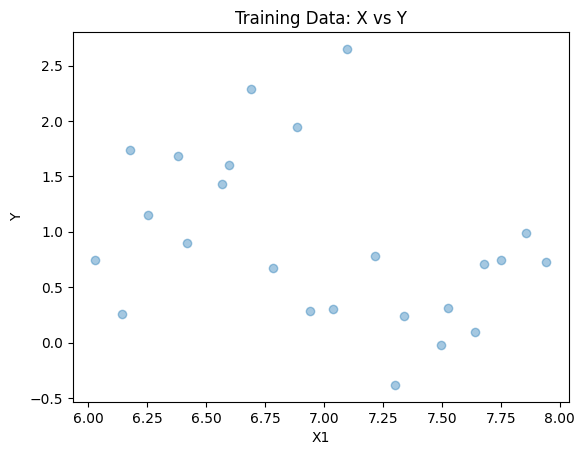

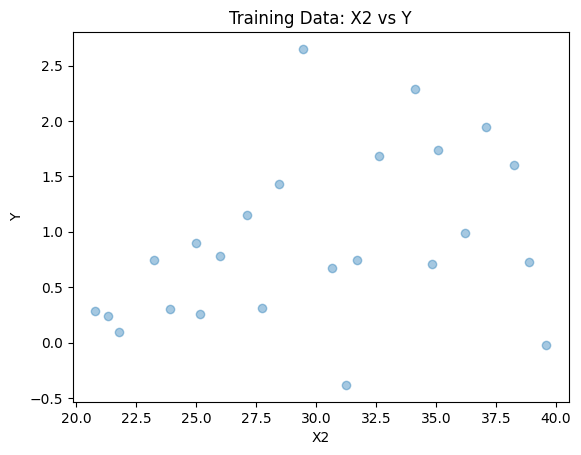

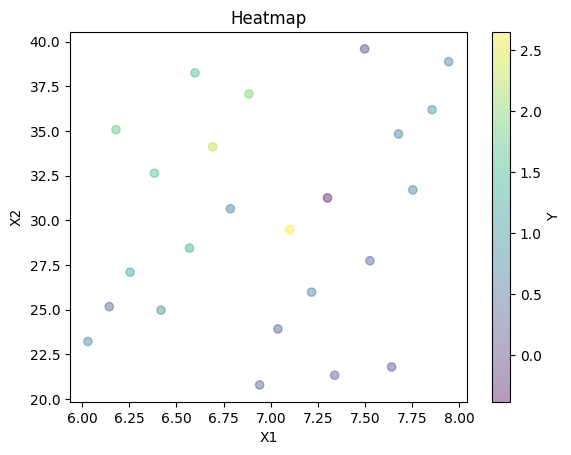

In [21]:
# Simple plot to see what training data looks like
# Run this after multiple BO LOOPS to see all training data.


plt.scatter(train_X[:, 0], train_Y, alpha=0.4)
plt.title("Training Data: X vs Y")
plt.xlabel("X1")
plt.ylabel("Y")
plt.show()

plt.scatter(train_X[:, 1], train_Y, alpha=0.4)
plt.title("Training Data: X2 vs Y")
plt.xlabel("X2")
plt.ylabel("Y")
plt.show()

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, alpha=0.4)
plt.title("Heatmap")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label='Y')
plt.show()


In [22]:
# Gaussian Process Model

# Only for further GP Model development

# Setup (Assume train_X, train_Y, bounds, and objective_function are defined)
# ===========================



# GP Model definition
class GPModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, fixed_noise=False, noise_level=noise_level,
                 lengthscale_prior=None, outputscale_prior=None,
                 lengthscale_constraint = None, outputscale_constraint=None):

        if fixed_noise:
            print(f"Training with FIXED noise: {noise_level*100:.1f}% of mean output.")
            noise_variance = (noise_level * train_Y.mean()).pow(2)
            train_Yvar = torch.full_like(train_Y, noise_variance)
            likelihood = None
            super().__init__(
                train_X, train_Y, train_Yvar=train_Yvar, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dim)
            )
        else:
            print("Training with LEARNABLE noise (Gaussian Likelihood).")
            likelihood = likelihoods.GaussianLikelihood()
            super().__init__(
                train_X, train_Y, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dim)
            )
            lower_noise = lower_noise_bound**2  # lower noise bound
            upper_noise = upper_noise_bound**2  # upper noise bound

            # Add a **prior** (softly nudges during training)
            self.likelihood.noise_covar.register_prior(
                "noise_prior",
                SmoothedBoxPrior(lower_noise, upper_noise),
                "raw_noise"
            )

            # Add a **constraint** (hard bounding box)
            self.likelihood.noise_covar.register_constraint(
                "raw_noise",
                Interval(lower_noise, upper_noise)
            )


        self.mean_module = means.ConstantMean()

        matern_kernel = kernels.MaternKernel(
            nu=nu,
            ard_num_dims=dim,
            lengthscale_prior=lengthscale_prior,
            lengthscale_constraint=lengthscale_constraint,
        )

        self.covar_module = kernels.ScaleKernel(
            base_kernel=matern_kernel,
            outputscale_prior=outputscale_prior,
            outputscale_constraint=outputscale_constraint,
        )
        #self.likelihood=likelihood  # I added this to fix for fixed, but it might be redundant

        
# Training function
def train_GP_model(train_X, train_Y, fixed_noise=False, noise_level=noise_level,
                   lengthscale_prior=None, outputscale_prior=None,
                   lengthscale_constraint = None, outputscale_constraint=None): 
    model = GPModel(
        train_X, train_Y,
        fixed_noise=fixed_noise,
        noise_level=noise_level,
        lengthscale_prior=lengthscale_prior,
        outputscale_prior=outputscale_prior,
        lengthscale_constraint = lengthscale_constraint, 
        outputscale_constraint=outputscale_constraint
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model, mll


Below, train_GP_model, is now designed to return model, mll, so YOU need to fix it (example is in
last line 'model_prior, _' so that it unpacks both) Or else it will cause problems later.

In [23]:
# tests to see that the model is working with fixed or learnable noise

# Train with fixed noise (10%)
model_fixed = train_GP_model(train_X, train_Y, fixed_noise=True, noise_level=noise_level)

# Train with learned noise
model_learn = train_GP_model(train_X, train_Y, fixed_noise=False)

Training with FIXED noise: 10.0% of mean output.
Training with LEARNABLE noise (Gaussian Likelihood).


In [24]:
# tests to see the model prediction vs true function

model, mll = train_GP_model(train_X, train_Y, noise_level=noise_level)
with torch.no_grad():
    model.eval()
    model.likelihood.eval()
    test_x = train_X  # we use training points
    posterior = model.posterior(test_x)
    pred_mean = posterior.mean
    pred_std = posterior.variance.sqrt()

    print(f"True Y (first 5):      {train_Y[:5].squeeze().numpy()}")
    print(f"Pred Mean (first 5):   {pred_mean[:5].squeeze().numpy()}")
    print(f"Pred Std Dev (first 5):{pred_std[:5].squeeze().numpy()}")


Training with LEARNABLE noise (Gaussian Likelihood).
True Y (first 5):      [1.73463084 0.74609377 0.89623386 0.2426846  0.30268757]
Pred Mean (first 5):   [1.72699951 0.74295121 0.89879141 0.24744494 0.31225335]
Pred Std Dev (first 5):[0.07656177 0.07645879 0.07651329 0.07654765 0.07643749]


In [25]:
# plot acquisition and GP surface
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_acquisition(acq_func, bounds, title="Acquisition Function"):
    """
    Plots a 2D acquisition function in raw input space.
    
    Parameters:
    - acq_func: acquisition function (expects unnormalized input)
    - bounds: tensor of shape [2, d] with raw input bounds
    - title: optional title for the plot
    """
    # Create a grid in raw space
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], 100)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], 100)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    X_normal = normalize(X_raw, bounds=bounds)
    with torch.no_grad():
        # Evaluate acquisition function (expects [n, 1, d])
        acq_values = acq_func(X_normal.unsqueeze(1)).squeeze(-1).cpu()

    # Reshape for heatmap
    Z = acq_values.reshape(100, 100)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X1.numpy(), X2.numpy(), Z.numpy(), levels=50, cmap="viridis")
    plt.colorbar(label="Acquisition Value")
    plt.xlabel("X1 (raw)")
    plt.ylabel("X2 (raw)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_gp_surface(model, bounds, grid_size=50, plot_type="mean", title=None):
    """
    Plots the posterior mean or standard deviation (uncertainty) of a 2D GP model.
    
    Parameters:
    - model: trained GP model (expects raw input if input_transform is set)
    - bounds: tensor of shape [2, d] with raw input bounds
    - grid_size: number of grid points per dimension
    - plot_type: "mean" or "std"
    - title: optional title for the plot
    """
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], grid_size)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], grid_size)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    with torch.no_grad():
        posterior = model.posterior(X_raw)
        if plot_type == "mean":
            Z = posterior.mean.reshape(grid_size, grid_size).cpu()
        elif plot_type == "std":
            Z = posterior.variance.sqrt().reshape(grid_size, grid_size).cpu()
        else:
            raise ValueError("plot_type must be 'mean' or 'std'")

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1.numpy(), X2.numpy(), Z.numpy(), cmap=cm.viridis)
    ax.set_xlabel("X1 (raw)")
    ax.set_ylabel("X2 (raw)")
    ax.set_zlabel(plot_type)
    ax.set_title(title or f"GP Posterior {plot_type.capitalize()} Surface")
    plt.tight_layout()
    plt.show()



=== Iteration 1 ===
Training with LEARNABLE noise (Gaussian Likelihood).


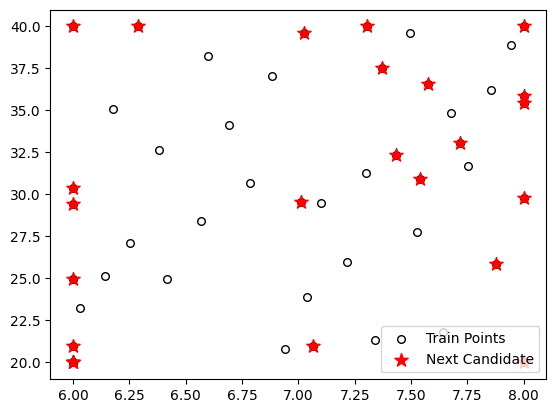

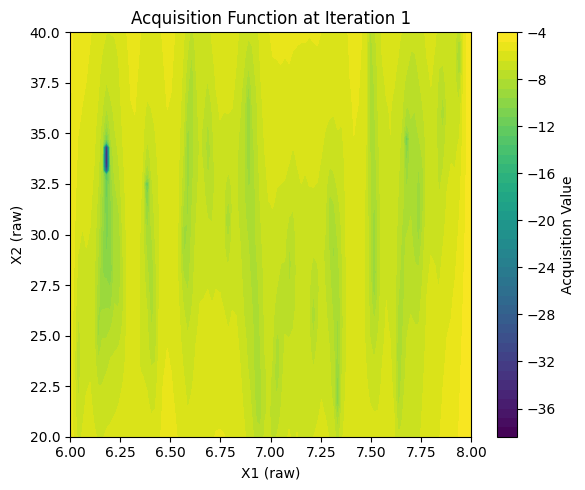

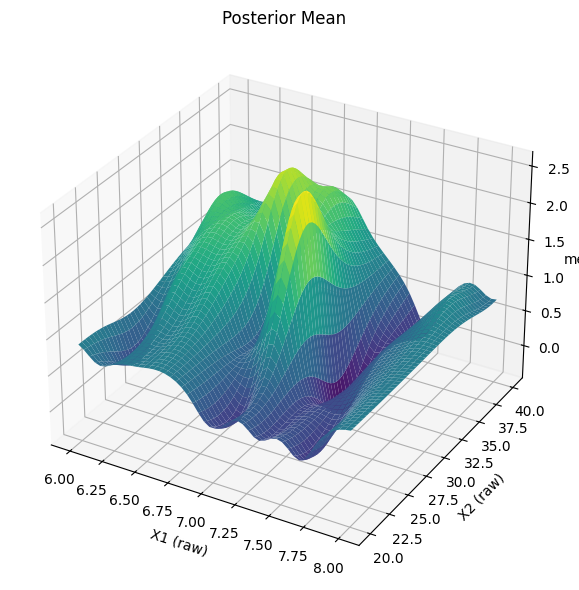

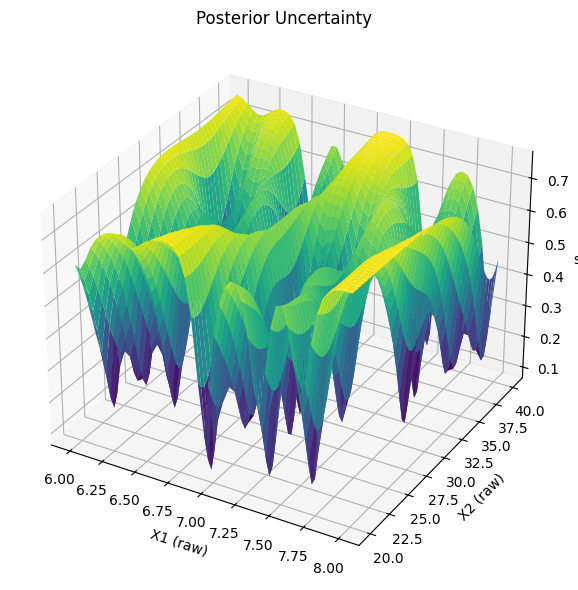

Best Y: 2.9505 at X: tensor([ 7.0096, 29.5280], dtype=torch.float64)
noise 0.010109082284742377
Lengthscales: tensor([[0.0608, 0.2025]], grad_fn=<SoftplusBackward0>)
Outputscale: tensor(1.0045, grad_fn=<SoftplusBackward0>)

=== Iteration 2 ===
Training with LEARNABLE noise (Gaussian Likelihood).


c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
c:\U

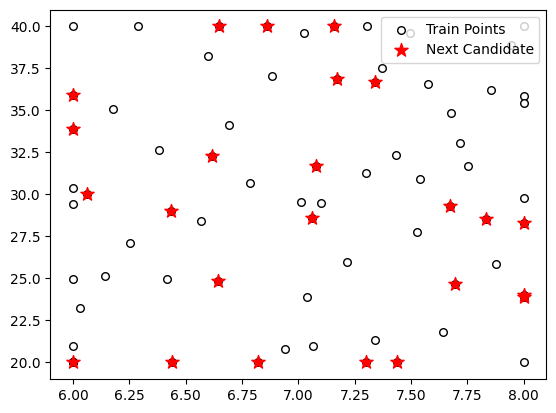

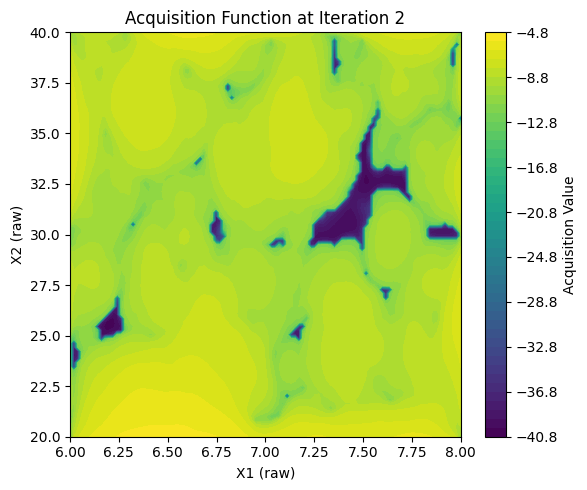

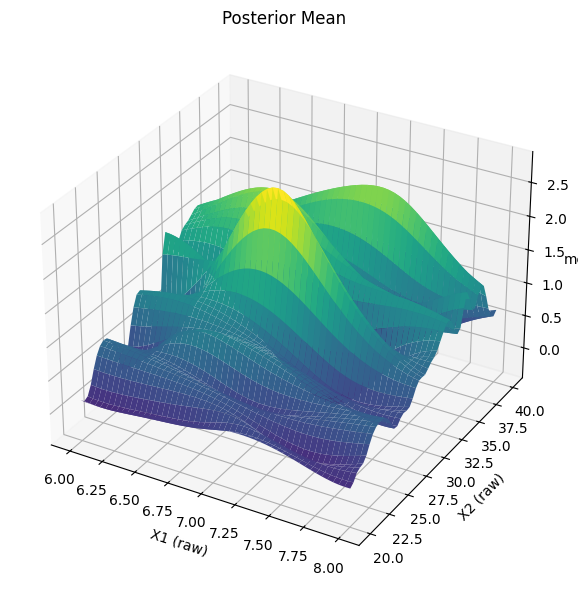

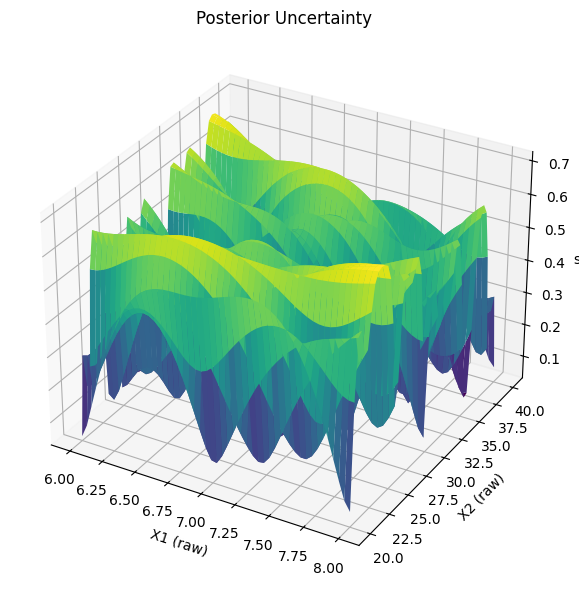

Best Y: 2.9505 at X: tensor([ 7.0096, 29.5280], dtype=torch.float64)
noise 0.010108091337674634
Lengthscales: tensor([[0.2645, 0.0420]], grad_fn=<SoftplusBackward0>)
Outputscale: tensor(0.8828, grad_fn=<SoftplusBackward0>)

=== Iteration 3 ===
Training with LEARNABLE noise (Gaussian Likelihood).


c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


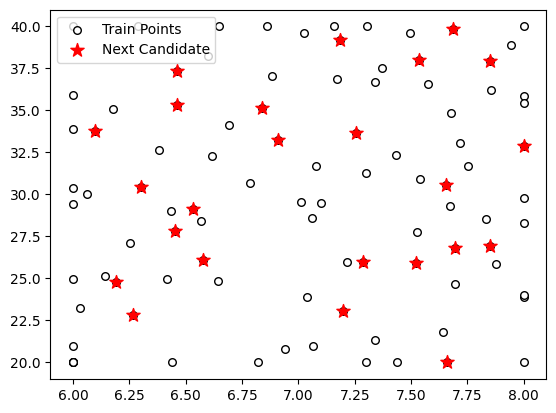

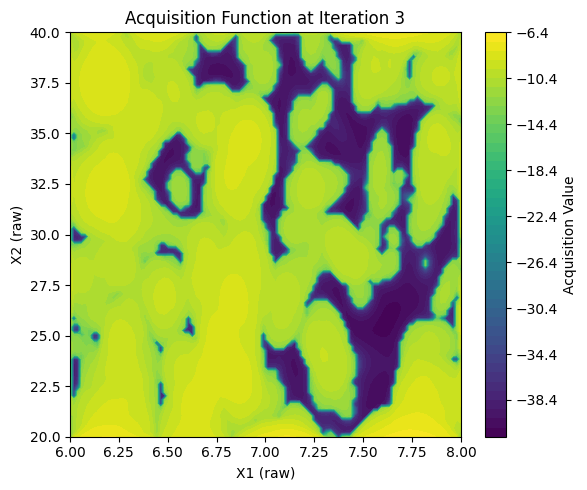

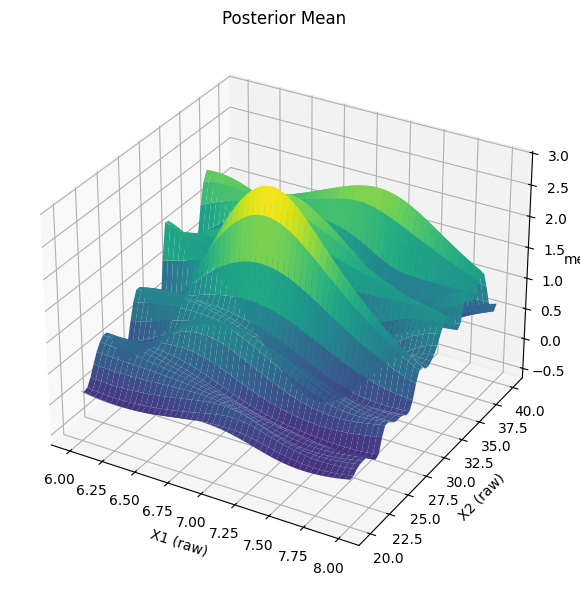

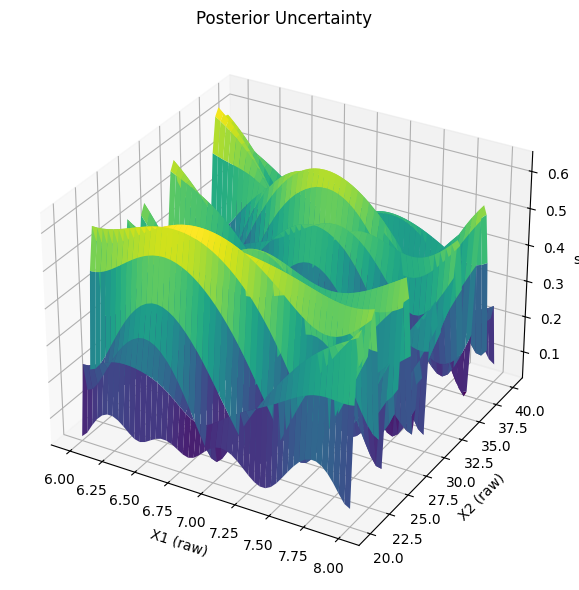

Best Y: 3.4406 at X: tensor([ 6.9093, 33.2408], dtype=torch.float64)
noise 0.010108082809884927
Lengthscales: tensor([[0.3266, 0.0500]], grad_fn=<SoftplusBackward0>)
Outputscale: tensor(0.9757, grad_fn=<SoftplusBackward0>)
Max predicted mean: 2.8700923259260334


In [26]:
# BO Loop
# ===========================
# The learning stacks, so you can repeat this loop to get better results.


normalized_bounds = torch.stack([torch.zeros(bounds.shape[1], dtype=bounds.dtype), 
                                 torch.ones(bounds.shape[1], dtype=bounds.dtype)
                                ])
n_iterations = 3 # of BO LOOP 
num_restarts = 30 # restarts loop if it can't converge answer (also can improve answer by finding a better local optima)
raw_samples = 50 # total resamples taken for analysis
batch_size = 24 # this is q THE REALWORLD # of EXPENSIVE EXPERIMENTS that your willing to do per BATCH

for iteration in range(n_iterations):
    print(f"\n=== Iteration {iteration + 1} ===")
    # Train model
    model, mll = train_GP_model(train_X, train_Y, 
                                #lengthscale_prior=lengthscale_prior, outputscale_prior=outputscale_prior, 
                                #lengthscale_constraint=lengthscale_constraint, outputscale_constraint=outputscale_constraint, 
                                fixed_noise=False)




    '''
    # Recompute batch_initial_conditions each iteration (important!)
    topk = torch.topk(train_Y.squeeze(), k=num_restarts, largest=True)
    batch_initial_conditions = X_normalized[topk.indices].unsqueeze(1)
    '''

    model.eval() #apparently this is good practice... though the model seemed to work fine before without this


    #best_f = model.outcome_transform(train_Y)[0].max().item() # best observed value so far (for EI)
    X_normalized = normalize(train_X, bounds)
    # Acquisition function (try switching between UCB and qLogNEI to compare)
    
    acq_func = qLogNoisyExpectedImprovement(model=model,
                                            X_baseline=X_normalized, 
                                            prune_baseline= True, # default is True, removes bad points from baseline (I set it to True as we're working with small data)
                                            cache_root= False, # True uses Cholesky decompositions speesd up acq func.
                                            )
     
    #acq_func = qUpperConfidenceBound(model=model, beta=3.0) # this is the UCB acquisition function

    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
    )

    # Unnormalize candidate
    candidate_raw = unnormalize(candidate, bounds=bounds)

    #print("Candidates (normalized):", candidate)
    #print("Candidates (raw):", candidate_raw)

    # Evaluate objective
    new_y = torch.stack([objective_function(c.unsqueeze(0))#, seed=seed) # seed = seed if you want to keep the same output each time. Removing it will simulate biological variability
                         for c in candidate_raw]
                        )
    train_X = torch.cat([train_X, candidate_raw], dim=0)
    train_Y = torch.cat([train_Y, new_y], dim=0)

    # Posterior info
    '''
    for i in range(batch_size):
        posterior = model.posterior(candidate_raw[i].unsqueeze(0))
        print(f"  Candidate {i+1}:")
        print(f"  Input: {candidate_raw[i].numpy()}")
        print(f"  Predicted mean: {posterior.mean.item():.4f}")
        print(f"  Predicted std:  {posterior.variance.sqrt().item():.4f}")
        print(f"  New y:          {new_y[i].item():.4f}")
    '''
    # Optional: Plot acquisition function
    plt.scatter(train_X[:, 0].cpu(), train_X[:, 1].cpu(), c="white", edgecolor="black", s=30, label="Train Points")
    plt.scatter(candidate_raw[:, 0].cpu(), candidate_raw[:, 1].cpu(), c="red", marker="*", s=100, label="Next Candidate")
    plt.legend()
    plot_acquisition(acq_func, bounds, title=f"Acquisition Function at Iteration {iteration+1}")
    plot_gp_surface(model, bounds, plot_type="mean", title="Posterior Mean")
    plot_gp_surface(model, bounds, plot_type="std", title="Posterior Uncertainty")

    plt.show()
    best_idx = torch.argmax(train_Y.squeeze(-1))
    best_X = train_X[best_idx]
    best_Y = train_Y[best_idx].item()
    print(f"Best Y: {best_Y:.4f} at X: {best_X}")
    print("noise", model.likelihood.noise_covar.noise.max().item())
    print("Lengthscales:", model.covar_module.base_kernel.lengthscale)
    print("Outputscale:", model.covar_module.outputscale)

#print("noise", model.likelihood.noise_covar.noise.max().item())
#print("Lengthscales:", model.covar_module.base_kernel.lengthscale)
#print("Outputscale:", model.covar_module.outputscale)
print("Max predicted mean:", model.posterior(train_X).mean.max().item())

In [27]:
# check to see how much datas you've collected
print (train_X.shape)
print (train_Y.shape)

torch.Size([96, 2])
torch.Size([96, 1])


In [28]:
# Summarize gp model function

def summarize_gp_model(model, X_train, X_test=None, save_csv=False, csv_path="gp_diagnostics.csv"):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(X_train)
        mean = posterior.mean
        stddev = posterior.variance.sqrt()

    # Extract parameters
    lengthscale = model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
    outputscale = model.covar_module.outputscale.detach().cpu().numpy()
    noise = model.likelihood.noise.detach().cpu().numpy()

    # Print diagnostics
    print("=== GP Model Diagnostics ===")
    print("ARD Lengthscales:", lengthscale)
    print("Outputscale:", outputscale)
    '''
    print("Noise:", noise)
    print("Predictive Mean (first 5):", mean[:5].squeeze().cpu().numpy())
    print("Predictive StdDev (first 5):", stddev[:5].squeeze().cpu().numpy())
    '''

    # === 2D Visualization ===
    if X_train.shape[1] == 2:
        x = X_train[:, 0].cpu().numpy()
        y = X_train[:, 1].cpu().numpy()
        z = mean.squeeze().cpu().numpy()
        err = stddev.squeeze().cpu().numpy()

        #tests
        #print(x)
        #print(y)
        #print(z)
        
        # Predictive mean scatter
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(x, y, c=z, cmap='viridis', s=60, edgecolor='k')
        plt.colorbar(sc, label="Predictive Mean")
        plt.xlabel("Input dim 0")
        plt.ylabel("Input dim 1")
        plt.title("Predictive Mean at Training Points")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Predictive stddev scatter
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(x, y, c=err, cmap='plasma', s=60, edgecolor='k')
        plt.colorbar(sc, label="Predictive Stddev")
        plt.xlabel("Input dim 0")
        plt.ylabel("Input dim 1")
        plt.title("Predictive Uncertainty at Training Points")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === Optional: grid-based contour ===
        if X_test is not None:
            model.eval()
            with torch.no_grad():
                test_posterior = model.posterior(X_test)
                test_mean = test_posterior.mean.cpu().numpy()
                test_stddev = test_posterior.variance.sqrt().cpu().numpy()

            xg = X_test[:, 0].cpu().numpy()
            yg = X_test[:, 1].cpu().numpy()
            zg = test_mean.squeeze()
            errg = test_stddev.squeeze()

            # Interpolate for contour plot
            xi = np.linspace(xg.min(), xg.max(), 100)
            yi = np.linspace(yg.min(), yg.max(), 100)
            Xi, Yi = np.meshgrid(xi, yi)
            Zi = griddata((xg, yg), zg, (Xi, Yi), method='cubic')
            Ei = griddata((xg, yg), errg, (Xi, Yi), method='cubic')

            # Contour plot for predictive mean
            plt.figure(figsize=(6, 5))
            cs = plt.contourf(Xi, Yi, Zi, cmap='viridis')
            plt.colorbar(cs, label="Predictive Mean")
            plt.xlabel("Input dim 0")
            plt.ylabel("Input dim 1")
            plt.title("GP Predictive Mean (Interpolated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Contour plot for stddev
            plt.figure(figsize=(6, 5))
            cs = plt.contourf(Xi, Yi, Ei, cmap='plasma')
            plt.colorbar(cs, label="Predictive Stddev")
            plt.xlabel("Input dim 0")
            plt.ylabel("Input dim 1")
            plt.title("GP Predictive Uncertainty (Interpolated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        print("2D visualization skipped: input is not 2D.")

    # Bar plot of inverse lengthscales
    inv_lengthscale = 1.0 / lengthscale
    norm_inv_lengthscale = inv_lengthscale / inv_lengthscale.sum()

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(norm_inv_lengthscale[0])), norm_inv_lengthscale[0])
    plt.title("Normalized Inverse Lengthscales (Feature Importance)")
    plt.xlabel("Input Dimension")
    plt.ylabel("Relative Importance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save to CSV
    if save_csv:
        df = pd.DataFrame({
            "lengthscale": lengthscale[0],
            "inv_lengthscale": inv_lengthscale[0],
            "norm_inv_lengthscale": norm_inv_lengthscale[0],
            "outputscale": [outputscale] * len(lengthscale[0]),
            "noise": [noise] * len(lengthscale[0]),
        })
        df.to_csv(csv_path, index=False)
        print(f"Diagnostics saved to {csv_path}")



=== GP Model Diagnostics ===
ARD Lengthscales: [[0.3266246  0.04999602]]
Outputscale: 0.975739


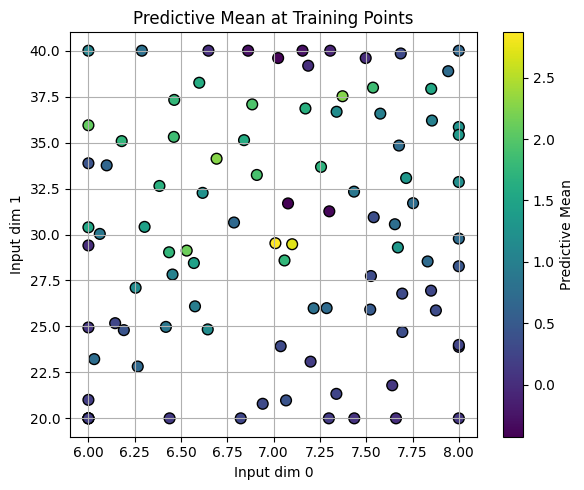

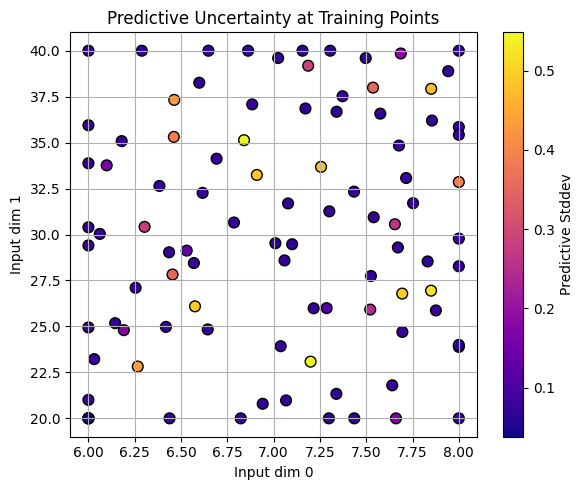

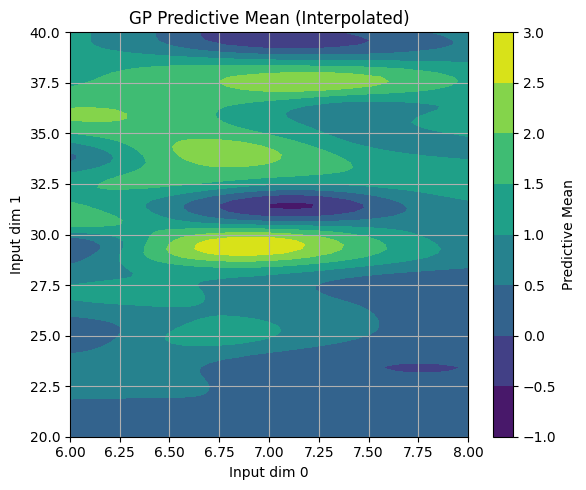

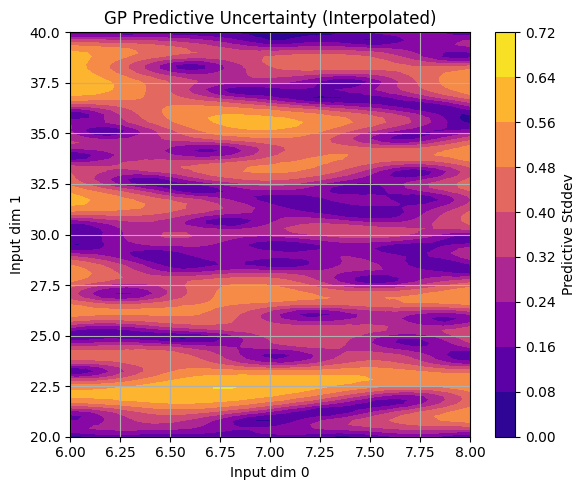

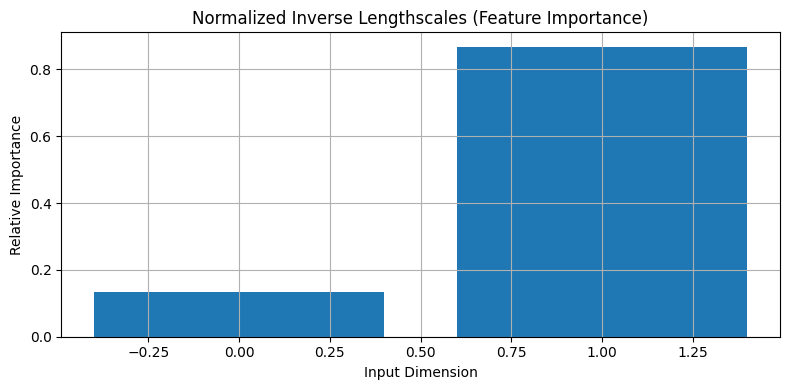

In [29]:
x1 = torch.linspace(6.0, 8.0, 50)
x2 = torch.linspace(20.0, 40.0, 50)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
X_test = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

summarize_gp_model(model, train_X, X_test=X_test)


In [30]:
def plot_bo_diagnostics(model, acq_func, train_X, bounds, latest_candidate, title_prefix="BO Diagnostics", grid_size=100):
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], grid_size)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], grid_size)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    with torch.no_grad():
        posterior = model.posterior(X_raw)
        mean = posterior.mean.reshape(grid_size, grid_size).cpu()
        std = posterior.variance.sqrt().reshape(grid_size, grid_size).cpu()

        X_norm = normalize(X_raw, bounds)
        acq_vals = acq_func(X_norm.unsqueeze(1)).squeeze(-1).reshape(grid_size, grid_size).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for ax, Z, cmap, title in zip(
        axs,
        [mean, std, acq_vals],
        ["viridis", "magma", "plasma"],
        ["Posterior Mean", "Posterior Std", "Acquisition Function"]
    ):
        im = ax.contourf(X1.numpy(), X2.numpy(), Z.numpy(), levels=50, cmap=cmap)
        ax.scatter(train_X[:, 0], train_X[:, 1], c='red', s=30, edgecolor='white', label='Train Points')
        ax.scatter(latest_candidate[:, 0], latest_candidate[:, 1], c='red', s=100, marker='*', label='Latest Candidate')
        ax.set_title(f"{title_prefix} - {title}")
        ax.set_xlabel("X1 (raw)")
        ax.set_ylabel("X2 (raw)")
        ax.legend()

    fig.colorbar(im, ax=axs[2], label="Acquisition Value")
    plt.tight_layout()
    plt.show()


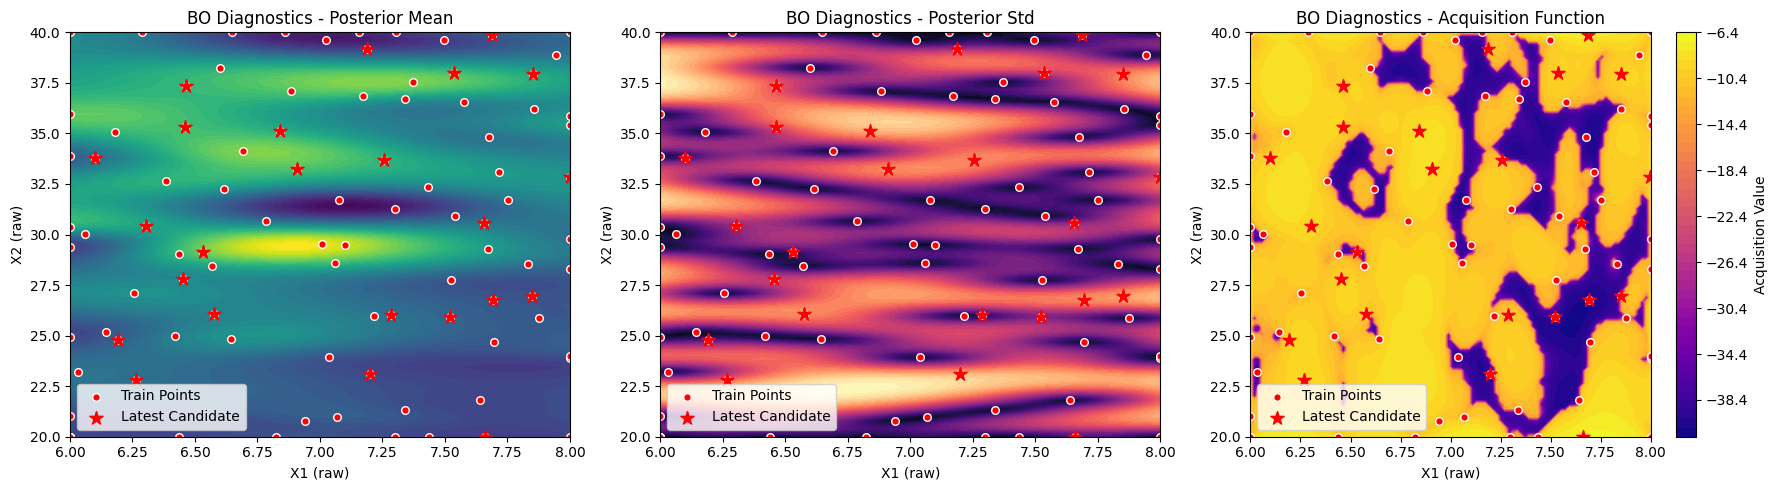

In [31]:
plot_bo_diagnostics(model, acq_func, train_X, bounds, candidate_raw)

In [32]:
def mse_loss(predictions, targets):
    return torch.mean((predictions - targets) ** 2)

def r_squared(predictions, targets):
    ss_total = torch.sum((targets - torch.mean(targets)) ** 2)
    ss_residual = torch.sum((targets - predictions) ** 2)
    return 1 - ss_residual / ss_total

def mape_loss(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets +1e-8)) * 100


model.eval()
with torch.no_grad():
    posterior_test = model.posterior(train_X)
    mean_test = posterior_test.mean
    stddev = posterior_test.variance.sqrt()

mse = mse_loss(mean_test, train_Y)
r2 = r_squared(mean_test, train_Y)
mape = mape_loss(mean_test, train_Y)

# print learned noise
print("Learned Noise:", model.likelihood.noise_covar.noise.max().item())

# Print the results
print(f"Mean Squared Error (MSE): {mse.item()}")
print(f"R²: {r2.item()}")
print(f"Mean Absolute Percentage Error (MAPE): {mape.item()}%")

true_Y = objective_function(train_X, noise_level=0.0)  # True function without noise
true_Y = true_Y.unsqueeze(-1)  # Reshape to (n, 1)
mse_true = mse_loss(mean_test, true_Y)
r2_true = r_squared(mean_test, true_Y)
mape_true = mape_loss(mean_test, true_Y)

# Print the results
print(f"True Function MSE: {mse_true.item()}")
print(f"True Function R²: {r2_true.item()}")
print(f"True Function MAPE: {mape_true.item()}%")

Learned Noise: 0.010108082809884927
Mean Squared Error (MSE): 0.09827625073493479
R²: 0.8452536351368958
Mean Absolute Percentage Error (MAPE): 70.39963719155404%
True Function MSE: 0.10259839919700693
True Function R²: 0.8356056124635212
True Function MAPE: 80.81681695984581%
